In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile
import csv
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [ ]:
# Install the Kaggle API
!pip install kaggle
# Authenticate and download the dataset
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

if os.path.exists('/content/COVID-19_Radiography_Dataset'):
    shutil.rmtree('/content/COVID-19_Radiography_Dataset')

!echo "Downloading files..."
!wget -q https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/download?datasetVersionNumber=5
!echo "Unzipping files..."
!unzip -q /content/covid19-radiography-database.zip


 99% 769M/778M [00:08<00:00, 115MB/s]
100% 778M/778M [00:08<00:00, 96.9MB/s]
Unzipping files...


In [ ]:

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training/

# Define the source directories
covid_source_dir = '/content/COVID-19_Radiography_Dataset/COVID/images/'
normal_source_dir = '/content/COVID-19_Radiography_Dataset/Normal/images/'
pneumonia_source_dir = '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/'
# otherInfections_source_dir = '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/'

# Define the destination directory
destination_dir = '/content/training/'

# Delete the existing training directory if it exists
if os.path.exists(destination_dir):
    shutil.rmtree(destination_dir)

# Create directories for normal and covid images within the destination directory
os.makedirs(os.path.join(destination_dir, 'covid'), exist_ok=True)
os.makedirs(os.path.join(destination_dir, 'normal'), exist_ok=True)
os.makedirs(os.path.join(destination_dir, 'pneumonia'), exist_ok=True)
# os.makedirs(os.path.join(destination_dir, 'other_infections'), exist_ok=True)


# Move covid images to the covid folder
covid_images = os.listdir(covid_source_dir)
for image in covid_images:
    shutil.move(os.path.join(covid_source_dir, image), os.path.join(destination_dir, 'covid', image))

# Move normal images to the normal folder
normal_images = os.listdir(normal_source_dir)
moved_count = 0
for image in normal_images:
    if moved_count < 3600:
        shutil.move(os.path.join(normal_source_dir, image), os.path.join(destination_dir, 'normal', image))
        moved_count += 1
    else:
        break

# Move pneumonia images to the pneumonia folder
pneumonia_images = os.listdir(pneumonia_source_dir)
for image in pneumonia_images:
    shutil.move(os.path.join(pneumonia_source_dir, image), os.path.join(destination_dir, 'pneumonia', image))

# moved_count = 0
# otherInfections_images = os.listdir(otherInfections_source_dir)
# for image in otherInfections_images:
#     if moved_count < 3600:
#         shutil.move(os.path.join(otherInfections_source_dir, image), os.path.join(destination_dir, 'other_infections', image))
#         moved_count += 1
#     else:
#         break

# Cleanup
!echo "Cleaning up..."
!rm covid19-radiography-database.zip

!echo "Data ready."

directory = '/content/training/'
num_items = len(os.listdir(directory))

print("Number of items in directory:", num_items)

Merging training data...
Cleaning up...
Data ready.
Number of items in directory: 3


In [ ]:
# USING MASKS
# # Move covid images to the covid folder and apply masks
# covid_images = os.listdir(covid_source_dir)
# for image_name in covid_images:
#     image_path = os.path.join(covid_source_dir, image_name)
#     mask_path = os.path.join(covid_masks_dir, image_name)

#     image = cv2.imread(image_path)
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#     # Resize the mask image to match the size of the regular image
#     mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

#     masked_image = cv2.bitwise_and(image, image, mask=mask.astype('uint8'))  # Convert mask to uint8

#     cv2.imwrite(os.path.join(destination_dir, 'covid', image_name), masked_image)

# # Move normal images to the normal folder and apply masks
# normal_images = os.listdir(normal_source_dir)
# for image_name in normal_images:
#     image_path = os.path.join(normal_source_dir, image_name)
#     mask_path = os.path.join(normal_masks_dir, image_name)

#     image = cv2.imread(image_path)
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#     # Resize the mask image to match the size of the regular image
#     mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

#     masked_image = cv2.bitwise_and(image, image, mask=mask.astype('uint8'))  # Convert mask to uint8

#     cv2.imwrite(os.path.join(destination_dir, 'normal', image_name), masked_image)

# print("Masks applied and images moved successfully.")

In [ ]:


# Define the source directory
training_dir = '/content/training/'
holdout_dir = '/content/holdout/'
csv_filename = 'holdout_set.csv'

# Create the holdout directory
if os.path.exists(holdout_dir):
    shutil.rmtree(holdout_dir)
if not os.path.exists(holdout_dir):
    os.makedirs(holdout_dir)

# Define the percentage of data to move to the holdout set
percentage_to_holdout = 0.05  # 5%

# Create a CSV file to record the file paths and labels
with open(csv_filename, mode='w', newline='') as csv_file:
    fieldnames = ['File_Path', 'Label']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    # Iterate over each class directory
    for class_name in os.listdir(training_dir):
        class_dir = os.path.join(training_dir, class_name)
        holdout_class_dir = os.path.join(holdout_dir, class_name)

        # Create the holdout class directory if it doesn't exist
        if not os.path.exists(holdout_class_dir):
            os.makedirs(holdout_class_dir)

        # List all files in the class directory
        files = os.listdir(class_dir)

        # Calculate the number of files to move to the holdout set
        num_files_to_holdout = int(len(files) * percentage_to_holdout)

        # Randomly select files to move to the holdout set
        files_to_holdout = random.sample(files, num_files_to_holdout)

        # Move the selected files to the holdout set and record their information in the CSV file
        for file_name in files_to_holdout:
            src = os.path.join(class_dir, file_name)
            dst = os.path.join(holdout_class_dir, file_name)
            shutil.move(src, dst)
            # Write the file path and label to the CSV file
            writer.writerow({'File_Path': dst, 'Label': class_name})

print("Holdout set creation completed.")
print("CSV file '{}' generated.".format(csv_filename))


Holdout set creation completed.
CSV file 'holdout_set.csv' generated.


In [ ]:
covid_images_dir = '/content/holdout/covid/'
normal_images_dir = '/content/holdout/normal/'
pneumonia_images_dir = '/content/holdout/pneumonia/'
other_infections_images_dir = '/content/holdout/other_infections/'
#masks_dir = '/content/COVID-19_Radiography_Dataset/Normal/masks/'

# Print out the contents of the directories
print("Contents of Covid holdout directory:", len(os.listdir(covid_images_dir)))
print("Contents of Normal holdout directory:", len(os.listdir(normal_images_dir)))
print("Contents of pneumonia holdout directory:", len(os.listdir(pneumonia_images_dir)))
# print("Contents of other_infection holdout directory:", len(os.listdir(other_infections_images_dir)))

Contents of Covid holdout directory: 180
Contents of Normal holdout directory: 180
Contents of pneumonia holdout directory: 67


In [ ]:
directory = '/content/training/covid'
num_items = len(os.listdir(directory))

print("Number of items in directory:", num_items)

Number of items in directory: 3436


In [ ]:
# Define the directories
covid_images_dir = '/content/training/covid/'
normal_images_dir = '/content/training/normal/'
pneumonia_images_dir = '/content/training/pneumonia/'
other_infections_images_dir = '/content/training/other_infections/'
#masks_dir = '/content/COVID-19_Radiography_Dataset/Normal/masks/'

# Print out the contents of the directories
print("Contents of Covid images directory:", len(os.listdir(covid_images_dir)))
print("Contents of Normal images directory:", len(os.listdir(normal_images_dir)))
print("Contents of pneumonia images directory:", len(os.listdir(pneumonia_images_dir)))
# print("Contents of other_infection images directory:", len(os.listdir(other_infections_images_dir)))

#print("Contents of Masks directory:", len(os.listdir(masks_dir)))


Contents of Covid images directory: 3436
Contents of Normal images directory: 3420
Contents of pneumonia images directory: 1278


In [ ]:
import tensorflow as tf

def apply_contrast_adjustment(image):
    # Generate a random factor for adjusting the contrast (between 0.5 and 1.5, for example)
    contrast_factor = tf.random.uniform(shape=[], minval=.6, maxval=1.4)

    # Calculate the mean pixel value of the image
    mean_pixel_value = tf.reduce_mean(image)

    # Adjust contrast by centering the pixel values around the mean and scaling by the contrast factor
    adjusted_image = (image - mean_pixel_value) * contrast_factor + mean_pixel_value

    # Clip the values to ensure they are within the valid range [0, 255]
    adjusted_image = tf.clip_by_value(adjusted_image, 0, 255)

    return adjusted_image


In [ ]:
training_dir = '/content/training/'
image_size = (299, 299)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.20,
    rotation_range=15,
    brightness_range=[0.9, 1.1],
    preprocessing_function=apply_contrast_adjustment,
    width_shift_range=0.05,
    height_shift_range=0.05
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    subset="training",
    batch_size=32,
    class_mode='sparse',  # Use binary class mode
    seed=42,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',  # Use binary class mode
    subset="validation",
    seed=42
)


Found 6508 images belonging to 3 classes.
Found 1626 images belonging to 3 classes.


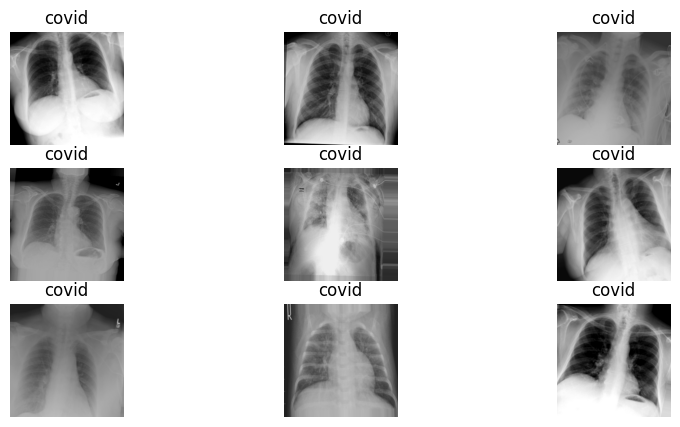

In [ ]:
target_names = ['covid', 'normal', 'pneumonia']#, 'other_infections']

# View 9 images and their class labels
plt.figure(figsize=(10, 5))
for images, labels in train_generator:
    for i in range(9):
        first_image = images[i]  # Accessing the ith image in the batch
        #print(first_image.dtype)
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image) * 255
        plt.imshow(f.astype("uint8"))
        plt.title(target_names[np.argmax(labels[i])])  # Use np.argmax to get the index of the maximum value in the label array
        plt.axis("off")
    break


In [ ]:
# # prompt: Loop over all the images and display 10 covid

# import matplotlib.pyplot as plt
# import numpy as np

# # Initialize counter
# counter = 0

# # Loop over all images in the training generator
# for images, labels in train_generator:
#     # Check if the label is "other_infections"
#     for i in range(len(labels)):
#         if target_names[np.argmax(labels[i])] == "covid":
#             # Display the image
#             plt.figure(figsize=(2,2))
#             f = np.array(images[i])*255
#             plt.imshow(f.astype("uint8"))
#             plt.show()

#             # Increment counter
#             counter += 1

#             # Check if we have displayed 10 images
#             if counter == 3:
#                 break

#     # Break the loop if we have displayed 10 images
#     if counter == 3:
#         break


In [ ]:
# Build a model...
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
# model.summary()


In [ ]:
output_classes = model.output_shape[-1]

# Check if the number of output classes matches the length of target_names
if output_classes == len(target_names):
    print("The model is using the following class names:")
    print(target_names)
else:
    print("The number of output classes does not match the length of target_names.")

The model is using the following class names:
['covid', 'normal', 'pneumonia']


In [ ]:
# opt = keras.optimizers.Adam(learning_rate=0.01)


# opt = keras.optimizers.Adam(learning_rate=0.0003)
# model.compile(optimizer=opt,
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
checkpoint_filepath = '/tmp/checkpoint6'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=8, validation_data=validation_generator,callbacks=[model_checkpoint_callback])

model.load_weights(checkpoint_filepath)

Epoch 1/8
204/204 [==============================] - 224s 1s/step - loss: 0.9165 - accuracy: 0.6212 - val_loss: 0.7333 - val_accuracy: 0.7079
Epoch 2/8
204/204 [==============================] - 219s 1s/step - loss: 0.6042 - accuracy: 0.7222 - val_loss: 0.5216 - val_accuracy: 0.7577
Epoch 3/8
204/204 [==============================] - 210s 1s/step - loss: 0.5315 - accuracy: 0.7529 - val_loss: 0.3702 - val_accuracy: 0.8524
Epoch 4/8
204/204 [==============================] - 199s 976ms/step - loss: 0.4860 - accuracy: 0.7872 - val_loss: 0.3909 - val_accuracy: 0.8327
Epoch 5/8
204/204 [==============================] - 206s 1s/step - loss: 0.4388 - accuracy: 0.8145 - val_loss: 0.3604 - val_accuracy: 0.8555
Epoch 6/8
204/204 [==============================] - 199s 978ms/step - loss: 0.4036 - accuracy: 0.8191 - val_loss: 0.3516 - val_accuracy: 0.8456
Epoch 7/8
204/204 [==============================] - 212s 1s/step - loss: 0.3868 - accuracy: 0.8357 - val_loss: 0.2976 - val_accuracy: 0.8875


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory of the holdout set
test_dir = '/content/holdout/'

# Create an ImageDataGenerator for preprocessing the images
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the holdout set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',  # Use sparse class mode for integer labels
    shuffle=False  # Do not shuffle the data
)


Found 427 images belonging to 3 classes.


In [ ]:


# Make predictions on the holdout set
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
# Save the predictions to a CSV file
# pd.DataFrame(predictions, columns=["predictions"]).to_csv("team6-module5-predictions.csv", index=False)
# print("Predictions saved to 'team6-module5-predictions.csv'.")
true_labels = test_generator.classes
predicted_labels = np.argmax(probabilities, axis=1)
accuracy = np.mean(predicted_labels == true_labels)
print(accuracy)

14/14 [==============================] - 4s 302ms/step
0.9016393442622951


In [ ]:
true_labels = test_generator.classes
predicted_labels = np.argmax(probabilities, axis=1)
accuracy = np.mean(predicted_labels == true_labels)
print("accuracy:", accuracy)


accuracy: 0.9016393442622951


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
validation_predictions = model.predict(validation_generator)
validation_predicted_labels = np.argmax(validation_predictions, axis=1)
validation_true_labels = validation_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(validation_true_labels, validation_predicted_labels)

# Calculate true positives, true negatives, false positives, and false negatives for each class
tp = conf_matrix.diagonal()
fp = conf_matrix.sum(axis=0) - tp
fn = conf_matrix.sum(axis=1) - tp
tn = conf_matrix.sum() - (tp + fp + fn)

# Calculate specificity and sensitivity for each class
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

# Print specificity and sensitivity for each class
for i in range(len(specificity)):
    print(f"Class {i}:")
    print("Specificity:", specificity[i])
    print("Sensitivity:", sensitivity[i])

holdout_accuracy = accuracy_score(validation_true_labels, validation_predicted_labels)

#print("\nHoldout Accuracy:", holdout_accuracy)

51/51 [==============================] - 11s 205ms/step
Class 0:
Specificity: 0.6293929712460063
Sensitivity: 0.3624454148471616
Class 1:
Specificity: 0.5573248407643312
Sensitivity: 0.44883040935672514
Class 2:
Specificity: 0.8110867979576951
Sensitivity: 0.1803921568627451


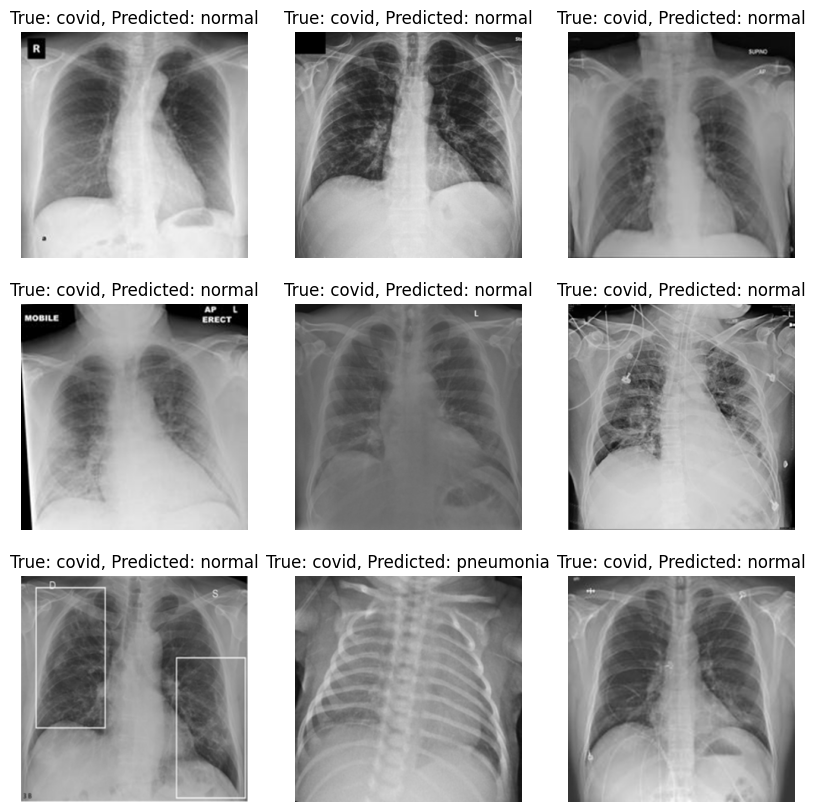

In [ ]:


# Define the directory of the holdout set
test_dir = '/content/holdout/'

# Load the true labels from the holdout set
true_labels = test_generator.classes

# Make predictions on the holdout set
predictions = np.argmax(probabilities, axis=1)

# Load the class labels used by the model
class_labels = {v: k for k, v in test_generator.class_indices.items()}

# Find misclassified samples
misclassified_indices = np.where(predictions != true_labels)[0]

# Display 9 misclassified images
num_images_to_display = min(9, len(misclassified_indices))
plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    index = misclassified_indices[i]
    img_path = test_generator.filepaths[index]
    img = load_img(img_path, target_size=image_size)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    true_label = class_labels[true_labels[index]]
    predicted_label = class_labels[predictions[index]]
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
plt.show()


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Define the directory containing the COVID images
covid_test_dir = '/content/holdout/covid/'

# Get the list of image files in the directory
image_files = [os.path.join(covid_test_dir, f) for f in os.listdir(covid_test_dir) if os.path.isfile(os.path.join(covid_test_dir, f))]

# Load and preprocess the images
preprocessed_images = []
for img_path in image_files:
    img = image.load_img(img_path, target_size=(299, 299))  # Assuming target size is (299, 299)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess the image
    preprocessed_images.append(img_array)

# Convert the list of preprocessed images to a numpy array
preprocessed_images = np.vstack(preprocessed_images)

# Make predictions
predictions = model.predict(preprocessed_images)

# Display or store predictions
count = 0
for i, img_path in enumerate(image_files):
  if count < 10:
    predicted_class_index = np.argmax(predictions[i])
    predicted_class = target_names[predicted_class_index]
    print(predicted_class)
    count += 1

6/6 [==============================] - 1s 43ms/step
covid
covid
covid
pneumonia
covid
pneumonia
covid
covid
covid
normal


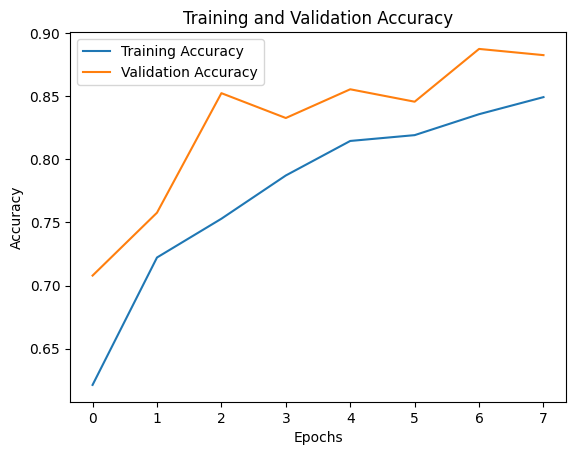

In [ ]:
import matplotlib.pyplot as plt

# Assuming you've trained your model and stored the training history in a variable called 'history'
# history = model.fit(train_generator, epochs=..., validation_data=validation_generator, ...)

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/holdout/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['covid', 'normal', 'pneumonia'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

Found 427 images belonging to 3 classes.
14/14 [==============================] - 4s 299ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Assuming you have the true labels for the test set
true_labels = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report
class_report = classification_report(true_labels, predictions, target_names=['covid', 'normal', 'pneumonia'])
# Extract precision, recall, and F1-score values for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predictions)


# Print classification report
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[157  20   3]
 [  9 166   5]
 [  1   4  62]]

Classification Report:
              precision    recall  f1-score   support

       covid       0.94      0.87      0.90       180
      normal       0.87      0.92      0.90       180
   pneumonia       0.89      0.93      0.91        67

    accuracy                           0.90       427
   macro avg       0.90      0.91      0.90       427
weighted avg       0.90      0.90      0.90       427



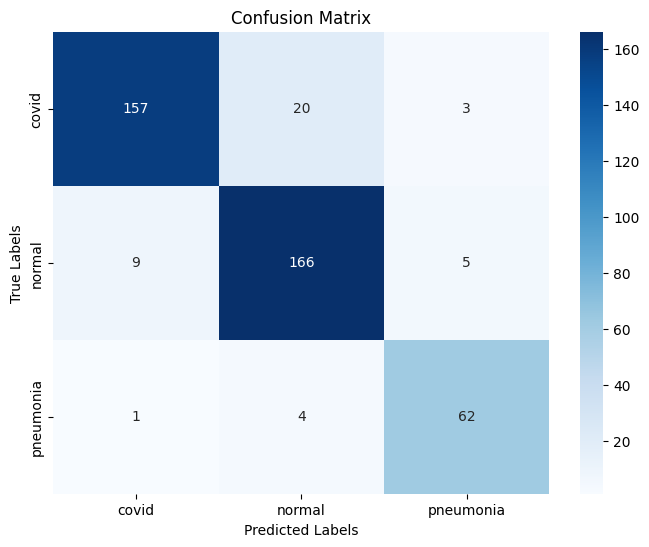

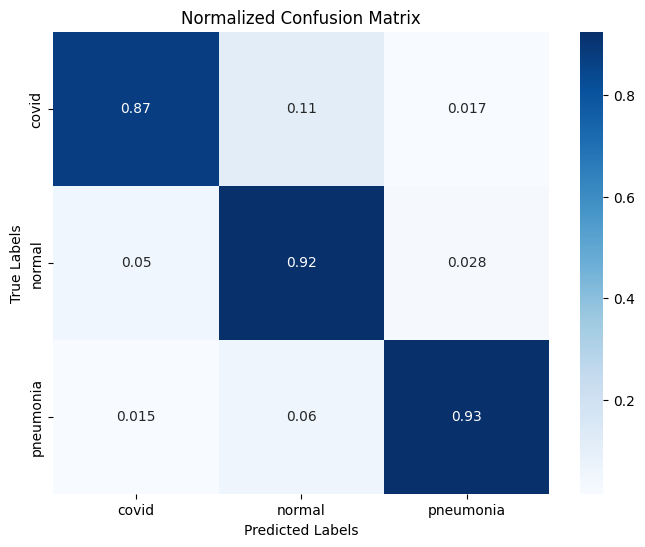

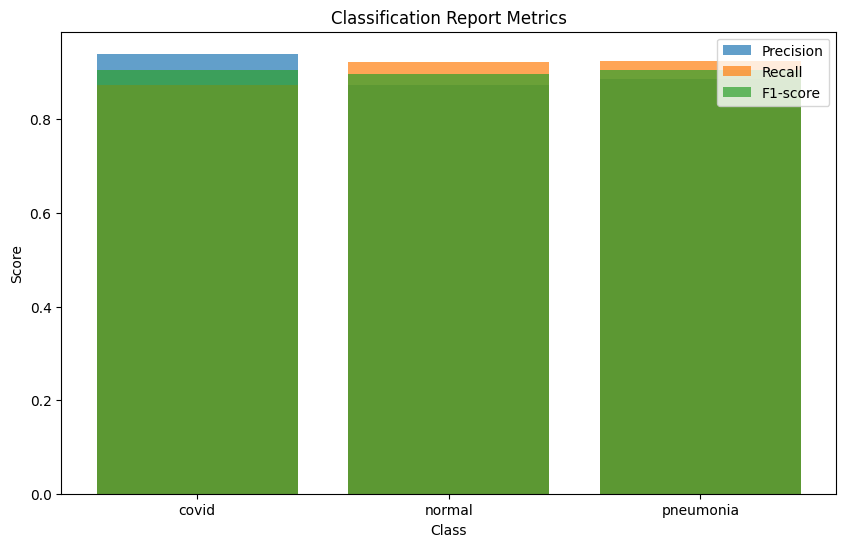

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the true labels for the test set
true_labels = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['covid', 'normal', 'pneumonia'], yticklabels=['covid', 'normal', 'pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot normalized confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, cmap='Blues', xticklabels=['covid', 'normal', 'pneumonia'], yticklabels=['covid', 'normal', 'pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# Plot classification report metrics
# precision = [0.95, 0.88, 0.92]  # Example precision values
# recall = [0.92, 0.94, 0.85]  # Example recall values
# f1_score = [0.93, 0.91, 0.88]  # Example F1-score values
labels = ['covid', 'normal', 'pneumonia']
plt.figure(figsize=(10, 6))
plt.bar(labels, precision, alpha=0.7, label='Precision')
plt.bar(labels, recall, alpha=0.7, label='Recall')
plt.bar(labels, f1_score, alpha=0.7, label='F1-score')
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Classification Report Metrics')
plt.legend()
plt.show()

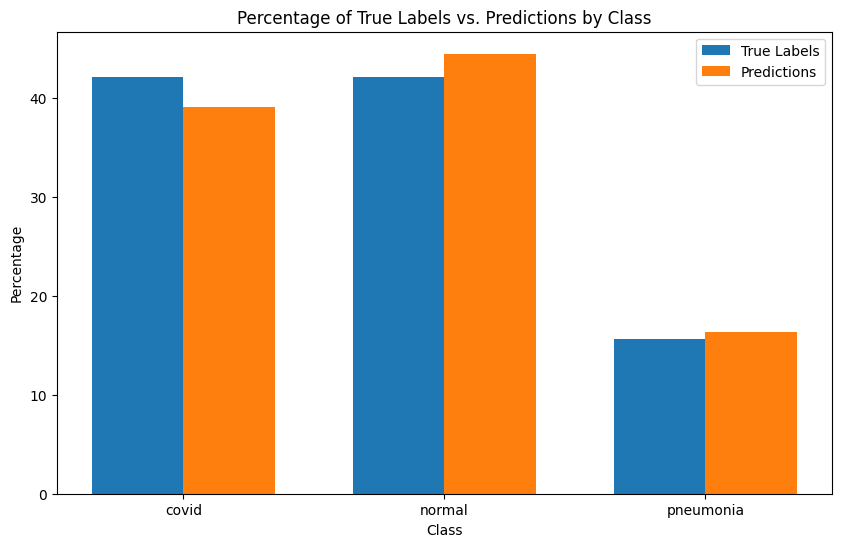

In [ ]:
# Compute the percentage of each class in true labels and predictions
true_label_counts = np.bincount(true_labels)
prediction_counts = np.bincount(predictions)

# Calculate percentages
true_label_percentages = true_label_counts / len(true_labels) * 100
prediction_percentages = prediction_counts / len(predictions) * 100

# Plot stacked bar chart
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
true_bars = ax.bar(x - width/2, true_label_percentages, width, label='True Labels')
pred_bars = ax.bar(x + width/2, prediction_percentages, width, label='Predictions')

ax.set_xlabel('Class')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of True Labels vs. Predictions by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


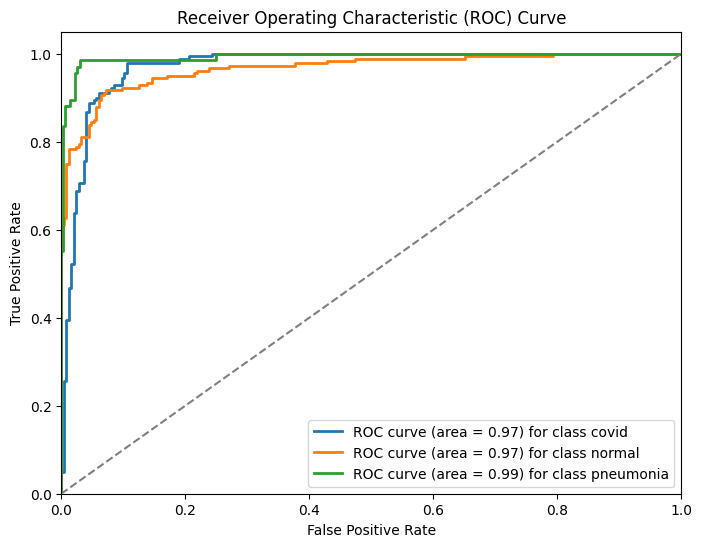

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], labels[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



|              | precision |   recall | f1-score |  support|
|--------------|---------- |----------|----------|---------|
|accuracy: 0.95|           |          |          |      201|
 |  macro: avg |       0.92|    0.92  |    0.91  |      201|
|weighted: avg |       0.97|   0.95   |    0.95  |      201|
